In [1]:
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import ast
import torch

batch_size = 256

DATASET_FOLDER = 'data'
FILENAME = 'data_pendulum_5000.csv'
EXTRACT_DATA = True
df = pd.read_csv(f'{FILENAME}')

if EXTRACT_DATA == True:
    observation_list = []
    action_list = []
    for item in df['states']:
        observation_list.append(ast.literal_eval(item))
    for item in df['actions']:
        action_list.append(ast.literal_eval(item))

    actions_np = np.array(action_list)
    observations_np = np.array(observation_list)
    # save the numpy arrays.
    np.save('observations.npy', observations_np)
    np.save('actions.npy', actions_np)
else:
    observations_np = np.load('observations.npy')
    actions_np = np.load('actions.npy')

rewards = df['reward'].values
terminations = df['done'].values

print('observations_np:', observations_np.shape)
print('actions_np:', actions_np.shape)
print('rewards:', rewards.shape)
print('terminations:', terminations.shape)

tensors = {}
tensors["observations"] = torch.tensor(observations_np, dtype=torch.float32)
tensors["actions"] = torch.tensor(actions_np, dtype=torch.float32)
tensors["rewards"] = torch.tensor(rewards, dtype=torch.float32)
tensors["next_observations"] = torch.cat([tensors["observations"][1:], torch.tensor(observations_np[-1:])[0][None]], dim=0)
tensors["terminals"] = torch.tensor(terminations, dtype=torch.float32)
tensordata = TensorDataset(tensors["observations"],
                            tensors["actions"],
                            tensors["rewards"][:, None],
                            tensors["next_observations"],
                            tensors["terminals"][:, None])
dataloader = DataLoader(tensordata, batch_size=batch_size, shuffle=True)
    

192275
observations_np: (192275, 3)
actions_np: (192275, 1)
rewards: (192275,)
terminations: (192275,)


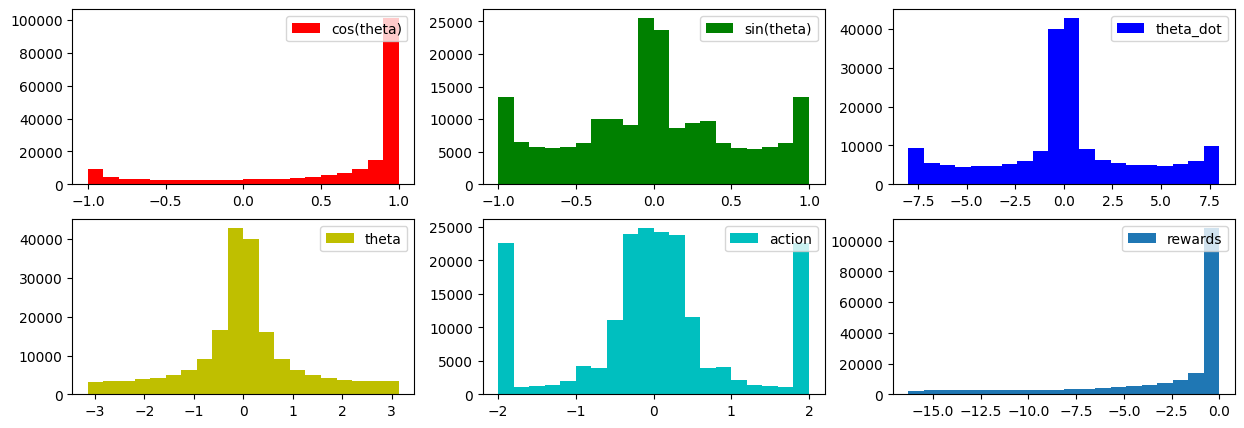

In [2]:
theta_angle = np.arctan2(observations_np[:, 1], observations_np[:, 0])


# plot histograms
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 3, figsize=(15, 5))
ax[0, 0].hist(observations_np[:, 0], bins=20, label='cos(theta)', color='r')
ax[0, 1].hist(observations_np[:, 1], bins=20, label='sin(theta)', color='g')
ax[0, 2].hist(observations_np[:, 2], bins=20, label='theta_dot', color='b')
ax[1, 0].hist(theta_angle, bins=20, label='theta', color='y')
ax[1, 1].hist(actions_np[:, 0], bins=20, label='action', color='c')
ax[1, 2].hist(rewards, bins=20, label='rewards')

for i in range(2):
    for j in range(3):
        ax[i, j].legend(loc='upper right')
plt.show()

Text(0, 0.5, 'Angular Velocity')

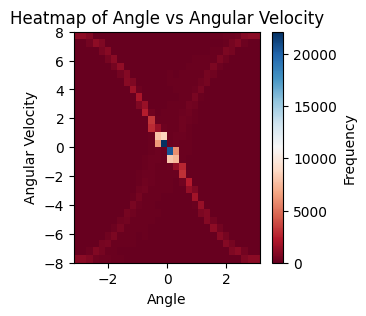

In [3]:
# plot heatmap
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
h = ax.hist2d(theta_angle, observations_np[:, 2], bins=30, cmap='RdBu')
# add legend

fig.colorbar(h[3], ax=ax, label='Frequency')
ax.set_title('Heatmap of Angle vs Angular Velocity')

ax.set_xlabel('Angle')
ax.set_ylabel('Angular Velocity')

In [4]:
does_it_sum_to_1 = observations_np[:, 0]**2 + observations_np[:, 1]**2
assert np.allclose(does_it_sum_to_1, 1, atol=1e-6), "The sum of the squares of the cos and sin of the angle should be 1"